fastai_statoil_motiur -- 2

Replicating: https://github.com/motiur/fastai/blob/master/statoil_4.ipynb

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys, os
sys.path.insert(1,os.path.join('../'))

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH  = "data/"; TRAIN = "train/"; VALID = "valid/"; TEST  = "test/"

In [7]:
train = pd.read_json(PATH+"train.json")
test  = pd.read_json(PATH+"test.json")

In [8]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([0.3*X_band_1[:, :, :, np.newaxis], 0.6*X_band_2[:, :, :, np.newaxis],(0.1*(X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [9]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([0.3*X_band_test_1[:, :, :, np.newaxis], 0.6*X_band_test_2[:, :, :, np.newaxis], (0.1*(X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [11]:
import sys
lenTrain = len(train)
print(lenTrain)
for i in range(0,lenTrain):
    isIceberg = (train.ix[i]['is_iceberg'])
    if(isIceberg == 1):scipy.misc.imsave(PATH+'train/iceberg.'+str(i)+'.jpg', X_train[i])
    else:scipy.misc.imsave(PATH+'train/ship.'+str(i)+'.jpg', X_train[i])

1604


In [45]:
%cd $TRAIN
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(400):
    os.rename(shuf[i], '../'+VALID+shuf[i])

In [49]:
%cd ../..
%cd $PATH$VALID
%mv iceberg.*.jpg ice/
%mv ship.*.jpg    ship/

/home/wnixalo/iceberg/temp
/home/wnixalo/iceberg/temp/data/valid


In [50]:
%cd ../..
%cd $PATH$TRAIN
%mv iceberg.*.jpg ice/
%mv ship.*.jpg    ship/

/home/wnixalo/iceberg/temp
/home/wnixalo/iceberg/temp/data/train


In [51]:
%cd ../..
%cd $PATH
lenTest = len(test)
print(lenTest)
for i in range(lenTest):
    scipy.misc.imsave(TEST+str(i)+'.jpg', X_test[i])

/home/wnixalo/iceberg/temp
/home/wnixalo/iceberg/temp/data
8424


In [54]:
%pwd

'/home/wnixalo/iceberg/temp/data'

In [56]:
ARCH = resnet50
sz   = 224

# IMPORTANT NOTE: PATH MUST BE ABSOLUTE PATH -- FOR IMAGE_CLASSIFIER_DATA.FROM_PATHS(..)
data = ImageClassifierData.from_paths(os.getcwd(), bs = 16,
                                      tfms=tfms_from_model(ARCH, sz,
                                                           aug_tfms=transforms_basic,
                                                           max_zoom = 1.0), 
                                      trn_name='train',val_name='valid', 
                                      test_name = 'test',num_workers=8)

In [57]:
learn = ConvLearner.pretrained(ARCH, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/wnixalo/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:34<00:00, 2938255.44it/s]


100%|██████████| 527/527 [02:18<00:00,  4.45it/s]


In [58]:
learn.fit(1e-2, 3)

[ 0.       0.48046  0.46676  0.7675 ]                      
[ 1.       0.56045  0.40745  0.795  ]                      
[ 2.       0.58357  0.40445  0.815  ]                      



In [61]:
test_preds = learn.predict(is_test=True)
print(test_preds.shape)

(8424, 2)


In [63]:
lrf = learn.lr_find()

 71%|███████   | 54/76 [00:00<00:03,  6.10it/s, loss=0.563]


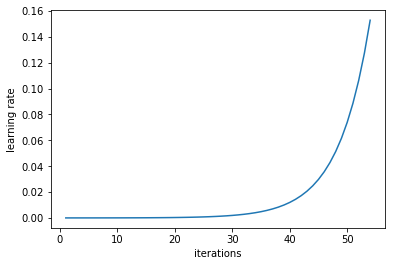

In [64]:
learn.sched.plot_lr()

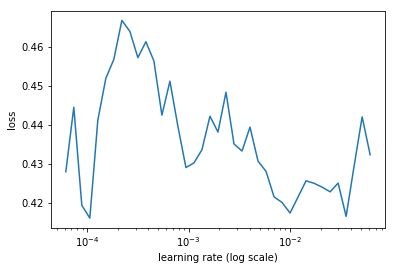

In [65]:
learn.sched.plot()

#### Differential Learning & Finetuning

In [67]:
learn.precompute=False
learn.fit(1e-2, 1, cycle_len=1)

[ 0.       0.44131  0.36507  0.8175 ]                      



In [68]:
# This gives the validation accuracy and log loss
from sklearn import metrics

log_preds, labels = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, labels), metrics.log_loss(labels, probs)

(0.8175, 0.35443731293466613)

In [69]:
learn.unfreeze()
lr = np.array([1e-2, 3e-2, 9e-2])

In [70]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)

[ 0.       1.89775  1.1183   0.595  ]                     
[ 1.       2.33167  2.34574  0.525  ]                     
[ 2.       1.39482  0.72513  0.62   ]                     
[ 3.       0.86514  0.58355  0.665  ]                      
[ 4.       0.80417  0.68014  0.5975 ]                      
[ 5.       0.72892  0.55509  0.69   ]                      
[ 6.       0.65658  0.58582  0.645  ]                      
[ 7.       0.63932  0.54809  0.6875 ]                      
[ 8.       0.64216  0.5953   0.6025 ]                      
[ 9.       0.62174  0.51948  0.7275 ]                      
[ 10.        0.61306   0.55096   0.71   ]                  
[ 11.        0.5994    0.52884   0.7225 ]                  
[ 12.        0.60868   0.52419   0.71   ]                  



In [71]:
# for file submission
test_preds = learn.TTA(is_test=True)
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = pd.DataFrame({'is_iceberg':list(np.exp(test_preds[0][:][:,0]))})
submission.to_csv('sub.csv', index=False)